載入所需要的套件

In [16]:
import numpy as np
import torch

## 基本設定
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## .xml檔案路徑
xml_path = "O-A0038-003.xml"

In [17]:
import xml.etree.ElementTree as ET
with open(xml_path, 'r', encoding='utf-8') as file:
    xml_content = file.read()
print(xml_content)

<?xml version="1.0" encoding="UTF-8"?> 
<cwaopendata xmlns="urn:cwa:gov:tw:cwacommon:0.1">
  <identifier>d39157c4-9871-11f0-b643-2c44fd85440d</identifier>
  <sender>od@cwa.gov.tw</sender> 
  <sent>2025-09-23T19:38:29+08:00</sent>
  <status>Actual</status>
  <msgType>Issue</msgType>
  <scope>Public</scope>
  <dataid>O-A0038-003</dataid>
  <dataset>
    <GeoInfo>
      <BottomLeftLongitude>120.0000</BottomLeftLongitude>
      <BottomLeftLatitude>21.8800</BottomLeftLatitude>
      <TopRightLongitude>121.9800</TopRightLongitude>
      <TopRightLatitude>25.4500</TopRightLatitude>
    </GeoInfo>
    <DataTime>
      <DateTime>2025-09-23T19:00:00+08:00</DateTime> 
    </DataTime>
    <Resource>
      <Description>此content之欄位內的格點資料浮點數值以逗號分隔，每一個數值以科學記號格式記錄，代表不同經緯度(TWD67)的溫度觀測值，單位為攝氏，資料無效值為-999.，經向及緯向解析度均為0.03度，每小時更新1筆資料。左下角為第一點東經為120.00度、北緯為21.88度，先依次經向遞增(總計67個數值)，再緯向遞增(總計120排)，形成一個67*120的數值資料網格。本產品係使用散布分布之氣象站溫度觀測值的距離權重法內插而來，因此除氣象站位置之格點溫度值為實測外，其餘格點皆為估計值，請謹慎使用。
      </Description>
<Content>-999

In [18]:
# 只讀取 <Content> 的格點資料，回傳 (H, W)
import re
import numpy as np
import xml.etree.ElementTree as ET

_FLOAT_RE = re.compile(r"""
    [-+]?                     # 符號
    (?:\d+(?:\.\d*)?|\.\d+)   # 整數或小數
    (?:[eE][-+]?\d+)?         # 科學記號，如 -999.0E+00
""", re.VERBOSE)

def _localname(tag: str) -> str:
    # 去 namespace，只留本名；例 {urn:xxx}Content -> Content
    return tag.rsplit('}', 1)[-1] if '}' in tag else tag

def read_content_grid_from_xml(xml_path: str, H=120, W=67, which=-1):
    """
    只抓 <Content> 內容：
      - 若檔案有多個 <Content>（多個時間切片），用 which 指定要第幾個（預設 -1 取最後一個）
      - 會把擷取到的數值最後 H*W 筆重塑成 (H, W)
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # 找所有 <Content> 節點（大小寫與 namespace 無關）
    contents = []
    for node in root.iter():
        if _localname(node.tag).lower() == "content":
            # 收集 text 與內層可能殘留的 text/tail，避免被切段
            chunk = []
            if node.text:
                chunk.append(node.text)
            for sub in node.iter():
                if sub is not node and sub.text:
                    chunk.append(sub.text)
                if sub.tail:
                    chunk.append(sub.tail)
            contents.append(" ".join(chunk))

    if not contents:
        raise ValueError("找不到 <Content>。")

    # 選擇要的 Content（預設最後一個）
    raw = contents[which]

    # 撈出所有數字（含科學記號）
    nums = _FLOAT_RE.findall(raw)
    vals = np.array([float(x) for x in nums], dtype=np.float32)

    grid = vals.reshape(H, W)      # (緯向列, 經向欄)
    return grid

grid = read_content_grid_from_xml(xml_path=xml_path)

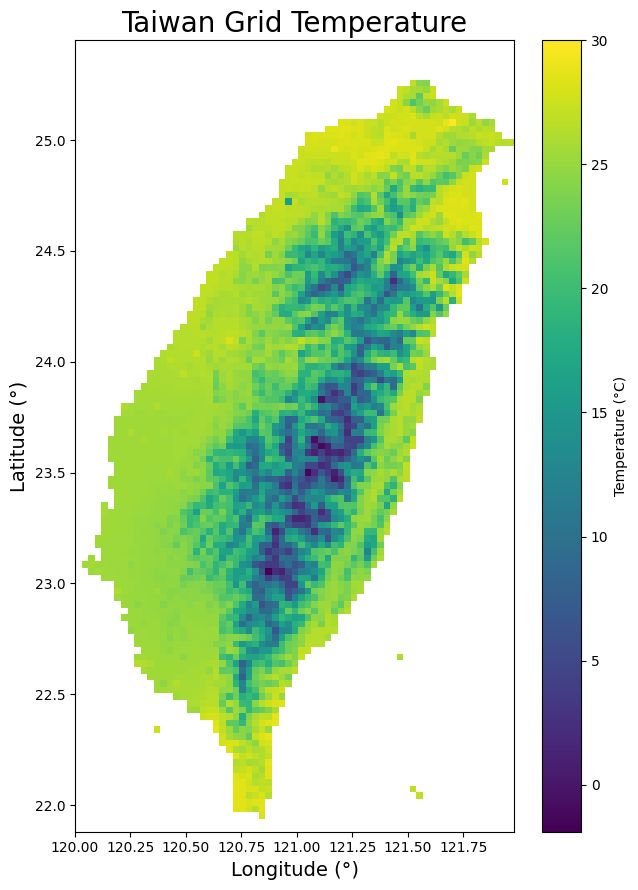

In [19]:
import numpy as np
import matplotlib.pyplot as plt

W = 67
H = 120
LON0, LAT0, RES = 120.0, 21.88, 0.03
# 座標範圍（左、右、下、上）
lon_min = LON0
lon_max = LON0 + RES * (W - 1)
lat_min = LAT0
lat_max = LAT0 + RES * (H - 1)

masked = np.ma.masked_equal(grid, -999.0)

plt.figure(figsize=(6.5, 9))
im = plt.imshow(
    masked,
    origin="lower",
    extent=[lon_min, lon_max, lat_min, lat_max],  # 把像素對應到經緯度
    aspect="auto",                                 # 不強制等比例，避免圖過扁
)
plt.xlabel("Longitude (°)", fontsize=14)
plt.ylabel("Latitude (°)", fontsize=14)
plt.colorbar(im, label="Temperature (°C)")
plt.title("Taiwan Grid Temperature", fontsize=20)
plt.tight_layout()
plt.show()


資料轉換

- 分類(Classification)資料集
    - 格式：``(經度, 緯度, label)``
    - 規則：
        - 若溫度觀測值為 **無效值 -999**，則``label = 0``。
        - 若溫度觀測值為 **有效值**，則``label = 1``。

- 迴歸(Regression)資料集
    - 格式：``(經度, 緯度, value)``
    - 規則：
        - 僅保留有效的溫度觀測值（剔除所有``-999.``）。
        - ``value``為對應的攝氏溫度。

In [20]:
import pandas as pd

def convert_and_save(grid: np.ndarray,
                     cls_csv="dataset_classification.csv",
                     reg_csv="dataset_regression.csv"):
    # 經緯度座標
    lons = LON0 + RES * np.arange(W, dtype=np.float32)
    lats = LAT0 + RES * np.arange(H, dtype=np.float32)
    lon_mat, lat_mat = np.meshgrid(lons, lats)  # (H, W)

    # 平展
    lon_flat = lon_mat.ravel()
    lat_flat = lat_mat.ravel()
    val_flat = grid.ravel()

    # 分類：-999 -> 0，其他 -> 1
    labels = (val_flat != -999.0).astype(np.int8)
    df_cls = pd.DataFrame({"longitude": lon_flat, "latitude": lat_flat, "label": labels})
    df_cls.to_csv(cls_csv, index=False)

    # 回歸：只留有效值
    mask = (val_flat != -999.0)
    df_reg = pd.DataFrame({
        "longitude": lon_flat[mask],
        "latitude":  lat_flat[mask],
        "value":     val_flat[mask].astype(np.float32)
    })
    df_reg.to_csv(reg_csv, index=False)

    # 簡要回傳 numpy 陣列（給 PyTorch 用）
    X_cls = np.stack([lon_flat, lat_flat], axis=1).astype(np.float32)
    y_cls = labels.astype(np.float32).reshape(-1, 1)
    X_reg = np.stack([lon_flat[mask], lat_flat[mask]], axis=1).astype(np.float32)
    y_reg = val_flat[mask].astype(np.float32).reshape(-1, 1)

    print(f"[分類] 總筆數={len(X_cls)}，label=1 有效值={mask.sum()}，label=0 無效值={(~mask).sum()}")
    print(f"[回歸] 總筆數={len(X_reg)}（已移除 -999）")
    print(f"已輸出：{cls_csv}, {reg_csv}")
    return (X_cls, y_cls), (X_reg, y_reg)

(X_cls, y_cls), (X_reg, y_reg) = convert_and_save(grid)

[分類] 總筆數=8040，label=1 有效值=3495，label=0 無效值=4545
[回歸] 總筆數=3495（已移除 -999）
已輸出：dataset_classification.csv, dataset_regression.csv


In [21]:
from torch.utils.data import TensorDataset, DataLoader

def add_fourier_features(X, m=8, scale=3.0):
    # X: (N,2) tensor（建議先做你原本的特徵標準化；如果沒做也能用）
    gammas = torch.tensor([2**k for k in range(m)], dtype=X.dtype, device=X.device) * scale
    lon, lat = X[:, :1], X[:, 1:2]
    feats = [X]
    for g in gammas:
        feats += [torch.sin(g*lon), torch.cos(g*lon),
                  torch.sin(g*lat), torch.cos(g*lat)]
    return torch.cat(feats, dim=1)

Xc, yc = torch.from_numpy(X_cls), torch.from_numpy(y_cls)
Xr, yr = torch.from_numpy(X_reg), torch.from_numpy(y_reg)

cls_dataset = TensorDataset(Xc, yc)
reg_dataset = TensorDataset(Xr, yr)

cls_dataloader = DataLoader(cls_dataset, batch_size=64, shuffle=True)
reg_dataloader = DataLoader(reg_dataset, batch_size=64, shuffle=True)

n_pos = float(yc.sum().item())
n_neg = float(yc.numel() - n_pos)
pos_w = torch.tensor(n_neg / max(n_pos, 1.0), device=device)

In [22]:
from torch import nn

def train_epoch(model, loss_fn, optimizer, dataloader):
    model.train()
    tot = 0.0

    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tot += loss.item() * x_batch.size(0)
    
    return tot / len(dataloader.dataset)

@torch.no_grad()
def eval_cls(model, dataloader):
    model.eval()
    correct, n = 0, 0
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        pred = (torch.sigmoid(model(x_batch)) > 0.5).float()
        correct += (pred.eq(y_batch)).sum().item()
        n += x_batch.size(0)
    
    return correct / n

@torch.no_grad()
def eval_reg(model, dataloader):
    model.eval()
    sse, n = 0.0, 0 # sse is sum of square error
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        pred = model(x_batch)
        sse += torch.sum((pred - y_batch) ** 2).item()
        n += x_batch.size(0)

    return np.sqrt(sse / n) # RMSE


cls_model = nn.Sequential(
    nn.Linear(2, 8),
    nn.ReLU(),
    nn.Linear(8, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
).to(device)

in_dim_reg = Xr.size(1)
reg_model = nn.Sequential(
    nn.Linear(2, 8),
    nn.ReLU(),
    nn.Linear(8, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
).to(device)


cls_optimizer = torch.optim.Adam(cls_model.parameters(), lr=1e-4)
reg_optimizer = torch.optim.Adam(reg_model.parameters(), lr=1e-4, weight_decay=0.01)
cls_loss = nn.BCEWithLogitsLoss(pos_weight=pos_w)
reg_loss = nn.SmoothL1Loss()


epochs_cls, epochs_reg = 150, 300
cls_training_losses = []
reg_training_losses = []

# ---- Classification ----
for epoch in range(1, epochs_cls + 1):
    training_loss = train_epoch(cls_model, cls_loss, cls_optimizer, cls_dataloader)
    cls_training_losses.append(training_loss)
    if epoch % 5 == 0 or epoch == epochs_cls:
        accuracy = eval_cls(cls_model, cls_dataloader)
        print(f"[Classification] epoch {epoch:02d} loss={training_loss:.4f} accuracy={accuracy:.4f}")

# ---- Regression ----
for epoch in range(1, epochs_reg + 1):
    training_loss = train_epoch(reg_model, reg_loss, reg_optimizer, reg_dataloader)
    reg_training_losses.append(training_loss)
    if epoch % 5 == 0 or epoch == epochs_reg:
        rmse = eval_reg(reg_model, reg_dataloader)
        print(f"[Regression] epoch {epoch:02d} loss{training_loss:.4f} RMSE={rmse:.4f}")

torch.save(cls_model.state_dict(), "cls_mlp.pt")
torch.save(reg_model.state_dict(), "reg_mlp.pt")
print("Saved: cls_mlp.pt, reg_mlp.pt")

[Classification] epoch 05 loss=0.8095 accuracy=0.5653
[Classification] epoch 10 loss=0.7976 accuracy=0.5653
[Classification] epoch 15 loss=0.7920 accuracy=0.5653
[Classification] epoch 20 loss=0.7845 accuracy=0.5653
[Classification] epoch 25 loss=0.7818 accuracy=0.5653
[Classification] epoch 30 loss=0.7815 accuracy=0.5336
[Classification] epoch 35 loss=0.7813 accuracy=0.5440
[Classification] epoch 40 loss=0.7810 accuracy=0.6327
[Classification] epoch 45 loss=0.7804 accuracy=0.6988
[Classification] epoch 50 loss=0.7798 accuracy=0.6182
[Classification] epoch 55 loss=0.7791 accuracy=0.6031
[Classification] epoch 60 loss=0.7782 accuracy=0.7129
[Classification] epoch 65 loss=0.7771 accuracy=0.6724
[Classification] epoch 70 loss=0.7756 accuracy=0.6728
[Classification] epoch 75 loss=0.7740 accuracy=0.7184
[Classification] epoch 80 loss=0.7723 accuracy=0.7086
[Classification] epoch 85 loss=0.7704 accuracy=0.7203
[Classification] epoch 90 loss=0.7681 accuracy=0.7117
[Classification] epoch 95 lo

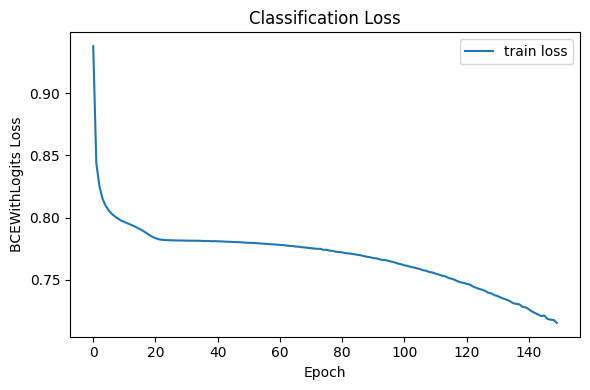

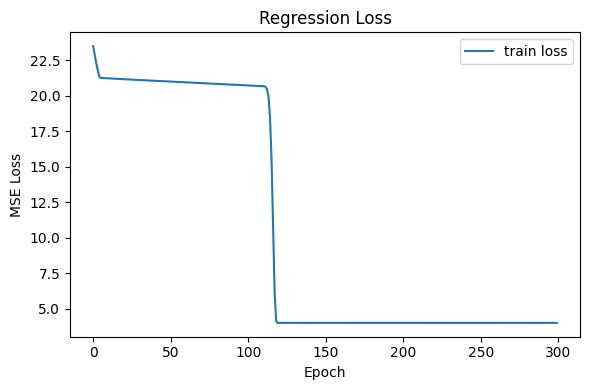

In [23]:
# Classification loss curve
plt.figure(figsize=(6,4))
plt.plot(cls_training_losses, label="train loss")
plt.xlabel("Epoch")
plt.ylabel("BCEWithLogits Loss")
plt.title("Classification Loss")
plt.legend()
plt.tight_layout()
plt.show()
# 若要存檔：plt.savefig("cls_loss.png", dpi=160)

# Regression loss curve
plt.figure(figsize=(6,4))
plt.plot(reg_training_losses, label="train loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Regression Loss")
plt.legend()
plt.tight_layout()
plt.show()
# 若要存檔：plt.savefig("reg_loss.png", dpi=160)


In [24]:
CLS_WEIGHTS = "cls_mlp.pt"
REG_WEIGHTS = "reg_mlp.pt"

cls_model = nn.Sequential(
    nn.Linear(2, 8),
    nn.ReLU(),
    nn.Linear(8, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
).to(device)

reg_model = nn.Sequential(
    nn.Linear(2, 8),
    nn.ReLU(),
    nn.Linear(8, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
).to(device)


cls_model.load_state_dict(torch.load(CLS_WEIGHTS, map_location=device))
reg_model.load_state_dict(torch.load(REG_WEIGHTS, map_location=device))
cls_model.eval()
reg_model.eval()

lons = LON0 + RES * np.arange(W, dtype=np.float32)
lats = LAT0 + RES * np.arange(H, dtype=np.float32)
lon_mat, lat_mat = np.meshgrid(lons, lats)              # (H,W)
X_all = np.stack([lon_mat.ravel(), lat_mat.ravel()], axis=1).astype(np.float32)

with torch.no_grad():
    X_all_t = torch.from_numpy(X_all).to(device)
    logit = cls_model(X_all_t)
    prob = torch.sigmoid(logit).squeeze(1)
    mask_pred = (prob > 0.5).cpu().numpy().reshape(H, W)
    y_reg_pred = reg_model(X_all_t).squeeze(1).cpu().numpy().reshape(H, W)



mask_true = (grid != -999.0)
y_true = mask_true.ravel().astype(int)
y_hat  = mask_pred.ravel().astype(int)
tp = int(((y_hat==1)&(y_true==1)).sum())
tn = int(((y_hat==0)&(y_true==0)).sum())
fp = int(((y_hat==1)&(y_true==0)).sum())
fn = int(((y_hat==0)&(y_true==1)).sum())
acc = (tp+tn) / (tp+tn+fp+fn+1e-12)
prec = tp / max(tp+fp, 1)
rec  = tp / max(tp+fn, 1)
f1   = 2*prec*rec / prec+rec

print(f"Confusion matrix  TP={tp}  FP={fp}  FN={fn}  TN={tn}")
print(f"Accuracy={acc:.4f}  Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")

Confusion matrix  TP=2591  FP=1319  FN=904  TN=3226
Accuracy=0.7235  Precision=0.6627  Recall=0.7413  F1=2.2240


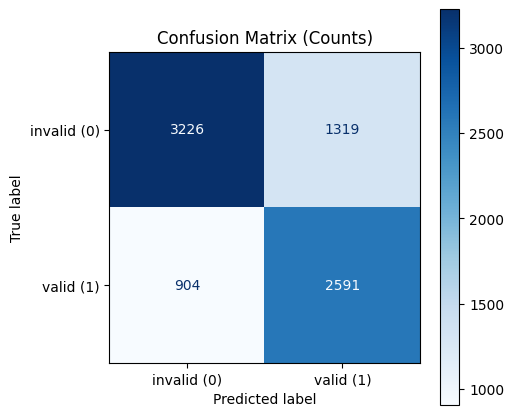

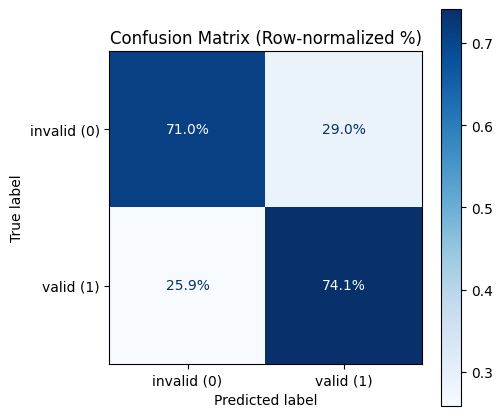

Accuracy=0.7235  Precision=0.6627  Recall=0.7413  F1=0.6998

Classification report:
              precision    recall  f1-score   support

 invalid (0)       0.78      0.71      0.74      4545
   valid (1)       0.66      0.74      0.70      3495

    accuracy                           0.72      8040
   macro avg       0.72      0.73      0.72      8040
weighted avg       0.73      0.72      0.72      8040



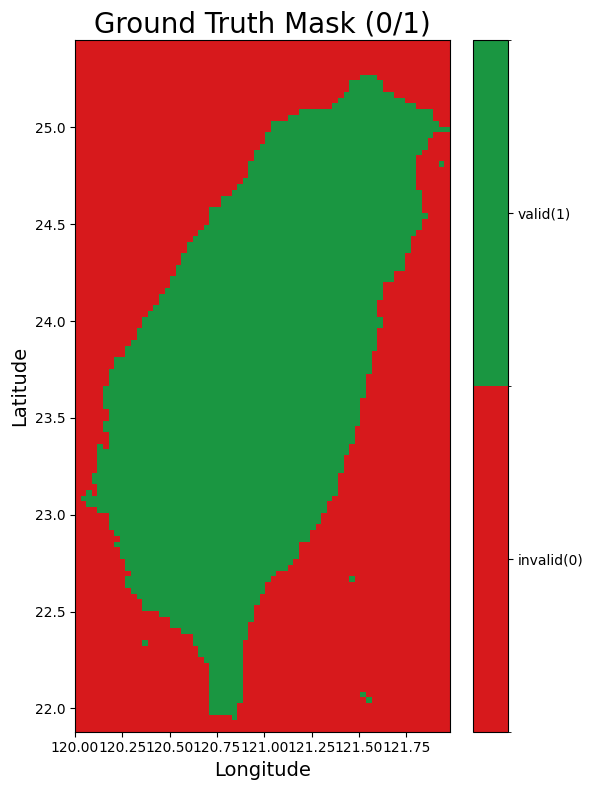

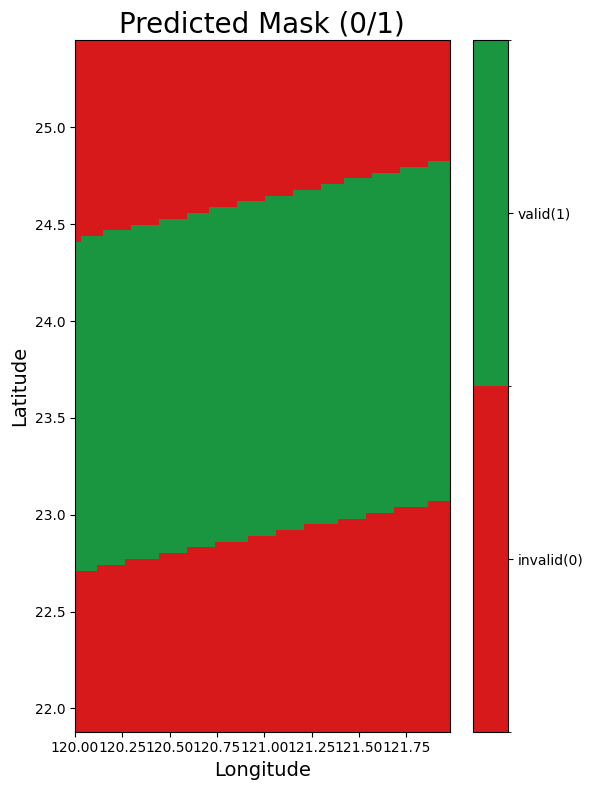

In [25]:
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score, classification_report
)

y_true_map = (grid != -999.0).astype(np.int8)     # 0=無效, 1=有效
y_pred_map = (prob > 0.5).cpu().numpy().astype(np.int8).reshape(H, W)  # 你的模型輸出

# 攤平成 1 維標籤
y_true = y_true_map.ravel().astype(int)
y_pred = y_pred_map.ravel().astype(int)

# ====== (A) 計數版混淆矩陣 ======
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["invalid (0)", "valid (1)"])
fig, ax = plt.subplots(figsize=(5.2, 4.6))
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=True)
ax.set_title("Confusion Matrix (Counts)")
plt.tight_layout(); plt.show()

# ====== (B) 列向正規化（百分比）版 ======
cmn = confusion_matrix(y_true, y_pred, labels=[0, 1], normalize="true")
disp_n = ConfusionMatrixDisplay(confusion_matrix=cmn,
                                display_labels=["invalid (0)", "valid (1)"])
fig, ax = plt.subplots(figsize=(5.2, 4.6))
disp_n.plot(ax=ax, cmap="Blues", values_format=".1%", colorbar=True)
ax.set_title("Confusion Matrix (Row-normalized %)")
plt.tight_layout(); plt.show()

# ====== 指標 ======
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec  = recall_score(y_true, y_pred, zero_division=0)
f1   = f1_score(y_true, y_pred, zero_division=0)
print(f"Accuracy={acc:.4f}  Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")

# 更完整的報表（含每類 precision/recall/f1）
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=["invalid (0)", "valid (1)"], zero_division=0))

# 經緯度範圍
lon_min, lon_max = LON0, LON0 + RES * (W - 1)
lat_min, lat_max = LAT0, LAT0 + RES * (H - 1)
extent = [lon_min, lon_max, lat_min, lat_max]

# 兩類配色（整張都畫，不做 mask）
cmap = ListedColormap(["#d7191c", "#1a9641"])  # 0=紅(無效), 1=綠(有效)
norm = BoundaryNorm([-0.5, 0.5, 1.5], cmap.N)

plt.figure(figsize=(6,8))
im = plt.imshow(y_true_map, origin="lower", extent=extent, aspect="auto",
                cmap=cmap, norm=norm, interpolation="nearest")
cbar = plt.colorbar(im, ticks=[0,1]); cbar.ax.set_yticklabels(["invalid(0)", "valid(1)"])
plt.title("Ground Truth Mask (0/1)", fontsize=20) 
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,8))
im = plt.imshow(y_pred_map, origin="lower", extent=extent, aspect="auto",
                cmap=cmap, norm=norm, interpolation="nearest")
cbar = plt.colorbar(im, ticks=[0,1]); cbar.ax.set_yticklabels(["invalid(0)", "valid(1)"])
plt.title("Predicted Mask (0/1)", fontsize=20) 
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.tight_layout()
plt.show()

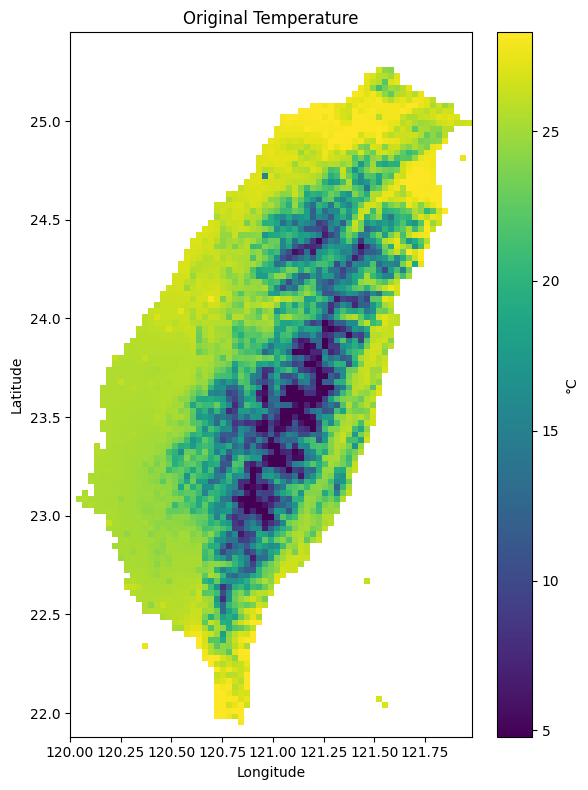

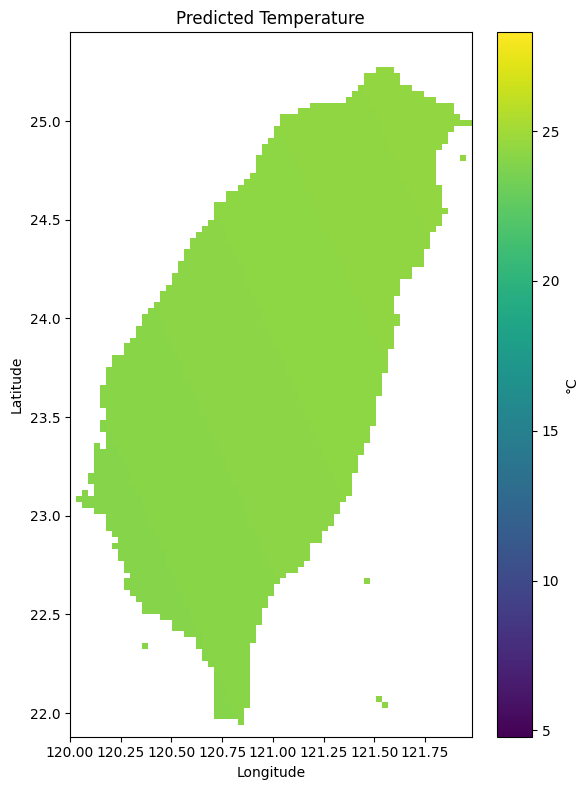

In [26]:
# 原始

lon_min, lon_max = LON0, LON0 + RES * (W - 1)
lat_min, lat_max = LAT0, LAT0 + RES * (H - 1)
extent = [lon_min, lon_max, lat_min, lat_max]


def show_valid_only(arr2d, valid_mask, title, cbar_label, vmin=None, vmax=None):
    to_show = np.where(valid_mask, arr2d, np.nan).astype(np.float32)
    m = np.ma.masked_invalid(to_show)
    plt.figure(figsize=(6, 8))
    im = plt.imshow(m, origin="lower", extent=extent, aspect="auto",
                    vmin=vmin, vmax=vmax)
    plt.colorbar(im, label=cbar_label)
    plt.title(title); plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.tight_layout(); plt.show()

# 可選：用有效值的分位數固定色階，讓原圖/預測圖一致
vmin, vmax = np.quantile(grid[mask_true], [0.02, 0.98])

# 1) 原始溫度（只畫有效格點）
show_valid_only(grid, mask_true, "Original Temperature", "°C",
                vmin=vmin, vmax=vmax)

# 2) 預測溫度（只在「真實有效格點」顯示）
show_valid_only(y_reg_pred, mask_true, "Predicted Temperature", "°C",
                vmin=vmin, vmax=vmax)